In [1]:
%matplotlib widget
import sys
import os
import subprocess
import torch
import numpy as np
import fileinput
import matplotlib.pyplot as plt
import torch.distributed as dist
import models
from dfd_utils.FaceForensicsDataset import FaceForensicsDataset
from dfd_utils.utils import plot_images, get_embeds, plot_embeddings_2D, plot_embeddings_3D
from dfd_utils.ImageAugmentation import get_transforms
from torch.utils.data import Subset
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 
from torchvision import transforms
from utils.datautils import CenterCropAndResize

from sklearn.manifold import TSNE
from matplotlib import cm

from torchvision import transforms, utils, datasets
import cv2
from facenet_pytorch import MTCNN
import random
from utils.datautils import CenterCropAndResize

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
!pip install tabulate
!pip install configargparse
!pip install filelock
!pip install strconv

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CONFIG_FILE_PATH =                '/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_train.yaml'
LIN_CLASSIFIER_CONFIG_FILE_PATH = '/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_eval.yaml'
EVAL_CONFIG_FILE_PATH = '/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_eval.yaml'

In [4]:
# Run this if the cmd cells below fail
os.environ['MKL_THREADING_LAYER'] = 'GNU'

### Print Help

In [43]:
cmd = f'python train.py --help --problem sim-clr'
!{cmd}

args: Namespace(ckpt='', config_file=None, deepfakes=False, dist='dp', dist_address='127.0.0.1:1234', eval_freq=10000000000000000, eval_only=False, iters=-1, log_freq=100, lr=0.1, lr_schedule='warmup-anneal', name='', new_transforms=True, node_rank=0, opt='lars', pretrained=False, problem='sim-clr', root='/mnt/results', save_freq=10000000000000000, seed=-1, tmp=False, verbose=False, warmup=0, weight_decay=0.0001, workers=4, world_size=1)
usage: train.py [-h] [--config CONFIG_FILE] [--tmp]
                [--problem {sim-clr,eval,semi-supervised-eval}] [--name NAME]
                [--ckpt CKPT] [--verbose VERBOSE] [--lr_schedule LR_SCHEDULE]
                [--opt {sgd,adam,lars}] [--iters ITERS] [--warmup WARMUP]
                [--lr LR] [--wd WEIGHT_DECAY] [--save_freq SAVE_FREQ]
                [--log_freq LOG_FREQ] [--eval_freq EVAL_FREQ] [-j WORKERS]
                [--eval_only EVAL_ONLY] [--seed SEED] [--root ROOT]
                [--deepfakes DEEPFAKES] [--pretrained PRETRAINE

In [14]:
cmd = f'python train.py --help --problem eval'
!{cmd}

args: Namespace(ckpt='', config_file=None, deepfakes=False, dist='dp', dist_address='127.0.0.1:1234', eval_freq=10000000000000000, eval_only=False, faceforensics_path='/media/shirbar/My Passport/FaceForensics/split_ds/', iters=-1, log_freq=100, lr=0.1, lr_schedule='warmup-anneal', name='', new_transforms=True, node_rank=0, opt='lars', pretrained=False, problem='eval', root='/mnt/results', save_freq=10000000000000000, seed=-1, tmp=False, verbose=False, warmup=0, weight_decay=0.0001, workers=4, world_size=1)
usage: train.py [-h] [--config CONFIG_FILE] [--tmp]
                [--problem {sim-clr,eval,semi-supervised-eval}] [--name NAME]
                [--ckpt CKPT] [--verbose VERBOSE] [--lr_schedule LR_SCHEDULE]
                [--opt {sgd,adam,lars}] [--iters ITERS] [--warmup WARMUP]
                [--lr LR] [--wd WEIGHT_DECAY] [--save_freq SAVE_FREQ]
                [--log_freq LOG_FREQ] [--eval_freq EVAL_FREQ] [-j WORKERS]
                [--eval_only EVAL_ONLY] [--seed SEED] [--root

### Train Base Model

In [21]:
cmd = f'python train.py --config {CONFIG_FILE_PATH} --dist ddp --dist_address localhost:8880 --node_rank 0'
!{cmd}

args: Namespace(ckpt='', config_file='/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_train.yaml', deepfakes=False, dist='ddp', dist_address='localhost:8880', eval_freq=330, eval_only=False, faceforensics_path='/media/shirbar/My Passport/FaceForensics/split_ds/', iters=11000, log_freq=110, lr=0.3, lr_schedule='warmup-anneal', name='ff-full-contrastive', new_transforms=True, node_rank=0, opt='lars', pretrained=False, problem='sim-clr', root='/mnt/results', save_freq=220, seed=42, tmp=False, verbose=True, warmup=0.1, weight_decay=1e-06, workers=8, world_size=1)
arch: ResNet50
aug: true
batch_size: 256
ckpt: ''
color_dist_s: 1.0
config_file: /srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_train.yaml
data: faceforensics
deepfakes: false
dist: ddp
dist_address: localhost:8880
eval_freq: 330
eval_only: false
faceforensics_path: /media/shirbar/My Passport/FaceForensics/split_ds/
iters: 11000
log_freq: 110
lr: 0.3
lr_schedule: warmup-

### Train Linear Classifier

In [11]:
encoder_path = '/media/shirbar/My Passport/trained_models/encoders/' + 'simclr_new_transforms_real_epoch_11000.pth.tar'
cmd = f'python train.py --config "{LIN_CLASSIFIER_CONFIG_FILE_PATH}" --dist dp --encoder_ckpt "{encoder_path}"'
!{cmd}

args: Namespace(ckpt='', config_file='/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_eval.yaml', deepfakes=True, dist='dp', dist_address='', eval_freq=4375, eval_only=False, faceforensics_path='/media/shirbar/My Passport/FaceForensics/split_ds/', iters=87500, log_freq=438, lr=0.0125, lr_schedule='linear', name='eval_faceforensics', new_transforms=False, node_rank=0, opt='sgd', pretrained=False, problem='eval', root='/mnt/results', save_freq=3500, seed=42, tmp=False, verbose=False, warmup=0.0, weight_decay=0.0, workers=8, world_size=1)
arch: linear
aug: true
augmentation: RandomResizedCrop
batch_size: 32
ckpt: ''
config_file: /srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_eval.yaml
data: faceforensics
deepfakes: true
dist: dp
dist_address: ''
encoder_ckpt: /media/shirbar/My Passport/trained_models/encoders/simclr_new_transforms_real_epoch_11000.pth.tar
eval_freq: 4375
eval_only: false
faceforensics_path: /media/shirbar/My Pas

### Eval Base Model

In [19]:
# Eval base model
encoder_path = '/media/shirbar/My\ Passport/trained_models/encoders/' + 'simclr_new_transforms_real_epoch_11000.pth.tar'

cmd = f'python train.py --config {EVAL_CONFIG_FILE_PATH} --dist dp --encoder_ckpt {encoder_path}'
!{cmd}

args: Namespace(ckpt='', config_file='/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_eval.yaml', deepfakes=True, dist='dp', dist_address='', eval_freq=4375, eval_only=False, faceforensics_path='/media/shirbar/My Passport/FaceForensics/split_ds/', iters=87500, log_freq=438, lr=0.0125, lr_schedule='linear', name='eval_faceforensics', new_transforms=False, node_rank=0, opt='sgd', pretrained=False, problem='eval', root='/mnt/results', save_freq=3500, seed=42, tmp=False, verbose=False, warmup=0.0, weight_decay=0.0, workers=8, world_size=1)
arch: linear
aug: true
augmentation: RandomResizedCrop
batch_size: 32
ckpt: ''
config_file: /srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/configs/ff_eval.yaml
data: faceforensics
deepfakes: true
dist: dp
dist_address: ''
encoder_ckpt: /media/shirbar/My Passport/trained_models/encoders/simclr_new_transforms_real_epoch_11000.pth.tar
eval_freq: 4375
eval_only: false
faceforensics_path: /media/shirbar/My Pas

# Compare the perfomance of the linear classifier to that of the KNN algorithm:
specifically we wanted to test the ability to detect different types of deepfake manipulations even ones not used in training
We want to evaluate these two method using 3 different encoders to create the latent space - SimCLR with the original augmentations, SimCLR with the new FF oriented augmentations and a ResNet-50 pretrained on ImageNet (no contrastive training)


## Load models:

In [5]:
def load_eval_model(eval_model_path, encoder_path):
    ckpt = torch.load(eval_model_path, map_location= DEVICE)
    ckpt['hparams'].deepfakes = False # don't put deepfakes in the train set
    ckpt['hparams'].encoder_ckpt = encoder_path
    model = models.ssl.SSLEval.load(ckpt, device=DEVICE)
    model.encoder.eval()
    model.eval()
    return model

#### Here you can find all the models we tested:
original_aug_model   -> simclr encoder, original augmentations, pre trained on Imagenet <br>
new_aug_model        -> simclr encoder, blackout augmentations, pre trained on Imagenet <br>
new_aug_no_pre_model -> simclr encoder, blackout augmentations, not pre trained on Imagenet <br>
resnet_model         -> resnet50 encoder, no augmentations, pre trained on Imagenet <br>

In [6]:
trained_models_folder = '/media/shirbar/My Passport/trained_models/' # Change this to the folder containing trained models


model_path = os.path.join(trained_models_folder,'linear_evals',
                                 'linear_eval_original_augs_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                'simclr_original_augs_pretrained_resnet.pth.tar')
original_aug_model = load_eval_model(model_path, encoder_path)


model_path = os.path.join(trained_models_folder,'linear_evals',
                                 'linear_eval_new_augs_pretrained_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                'simclr_new_augs_pretrained_only_real.pth.tar')
#new_aug_model = load_eval_model(model_path, encoder_path)


model_path = os.path.join(trained_models_folder,'linear_evals',
                                 'linear_eval_new_augs_no_pretrain_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders',
                                'simclr_new_transforms_real_epoch_11000.pth.tar')
new_aug_no_pre_model = load_eval_model(model_path, encoder_path)


resnet_path = os.path.join(trained_models_folder,'linear_evals',
                                 'linear_eval_resnet_100epochs.pth.tar')
encoder_path = os.path.join(trained_models_folder,'encoders'
                                                   'andrew_resnet.pth.tar')
#resnet_model = load_eval_model(model_path, encoder_path)


{'config_file': 'configs/ff_eval.yaml', 'tmp': False, 'problem': 'eval', 'name': 'eval_faceforensics', 'ckpt': '', 'verbose': False, 'lr_schedule': 'linear', 'opt': 'sgd', 'iters': 87500, 'warmup': 0.0, 'lr': 0.0125, 'weight_decay': 0.0, 'save_freq': 3500, 'log_freq': 438, 'eval_freq': 4375, 'workers': 8, 'eval_only': False, 'seed': 42, 'root': PosixPath('/srv/DeepFakeDetection/andrew_atonov_simclr_pytorch/simclr-pytorch/logs/exman-train.py/runs/000213'), 'deepfakes': False, 'pretrained': False, 'new_transforms': False, 'dist': 'dp', 'dist_address': '', 'node_rank': 0, 'world_size': 1, 'data': 'faceforensics', 'arch': 'linear', 'batch_size': 32, 'aug': True, 'test_bs': 32, 'encoder_ckpt': '/media/shirbar/My Passport/trained_models/encoders/simclr_original_augs_pretrained_resnet.pth.tar', 'precompute_emb_bs': -1, 'finetune': False, 'augmentation': 'RandomResizedCrop', 'scale_lower': 0.08, 'gpu': 0, 'number_of_processes': 1, 'rank': 0}
no path to faceforensics, using path from passed pat

# Load train dataset and create/load embeddings:
creating the embeddings may take some time, you can optionally upload them from a saved file

In [12]:
# the train set images are the same for all models so we can just load the train set once:
original_aug_model.prepare_data()
train_loader, test_loader = original_aug_model.dataloaders()
train_loader.dataset.dataset.dataset.transform = test_loader.dataset.dataset.dataset.transform

NameError: name 'original_aug_model' is not defined

In [64]:
_, original_aug_train_embeds, train_targets = get_embeds(original_aug_model, train_loader)
_, new_aug_train_embeds, _ = get_embeds(new_aug_model, train_loader)
_, new_aug_no_pre_train_embeds, _ = get_embeds(new_aug_no_pre_model, train_loader)
_, resnet_train_embeds,_ = get_embeds(resnet_model, train_loader)


  0%|          | 3/875 [00:01<17:14,  1.19s/it]

before: 255, 0
after: 1.0, 0.0


  0%|          | 1/875 [00:01<24:36,  1.69s/it]

before: 255, 0
after: 1.0, 0.0


  0%|          | 1/875 [00:01<22:16,  1.53s/it]

before: 255, 0
after: 1.0, 0.0


  0%|          | 2/875 [00:01<16:20,  1.12s/it]

before: 255, 0
after: 1.0, 0.0


  0%|          | 1/875 [00:01<24:17,  1.67s/it]

before: 255, 0
after: 1.0, 0.0


100%|██████████| 875/875 [01:40<00:00,  8.72it/s]


In [6]:
# save your embeddings if you wish:
torch.save({'embeddings': original_aug_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/original_augs_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_all_train_set_embeds_real.pt')
torch.save({'embeddings': resnet_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/resnet_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_no_pre_train_embeds, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt')
torch.save({'embeddings': new_aug_no_pre_train_embeds2, 'targets':train_targets},'/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real2.pt')


NameError: name 'original_aug_train_embeds' is not defined

## alternatively you can load the embeddings we used from file:

In [179]:
org_aug_path = '/media/shirbar/My Passport/trained_models/embeddings/original_augs_all_train_set_embeds_real.pt'
new_aug_path = '/media/shirbar/My Passport/trained_models/embeddings/new_augs_all_train_set_embeds_real.pt'
new_aug_no_pre_path = '/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt'
new_aug_no_pre_path2 = '/media/shirbar/My Passport/trained_models/embeddings/new_augs_no_pre_all_train_set_embeds_real.pt'
resnet_path = '/media/shirbar/My Passport/trained_models/embeddings/resnet_all_train_set_embeds_real.pt'

chkpt = torch.load(org_aug_path)
original_aug_train_embeds, train_targets = chkpt['embeddings'], chkpt['targets']
chkpt = torch.load(new_aug_path)
new_aug_train_embeds = chkpt['embeddings']
chkpt = torch.load(new_aug_no_pre_path)
new_aug_no_pre_train_embeds = chkpt['embeddings']
chkpt = torch.load(new_aug_no_pre_path2)
new_aug_no_pre_train_embeds2 = chkpt['embeddings']
chkpt = torch.load(resnet_path)
resnet_train_embeds = chkpt['embeddings']

In [ ]:
# Train classificaiton Head

In [ ]:
# Load checkpoint

## Plot Embeddings

### Load Model

In [25]:
# Choose which model you want to use to plot:
model = new_aug_no_pre_model
#model = resnet_model
#model = new_aug_model
#model = original_aug_model

### Load FaceForensics Dataset

In [19]:
def load_ff_ds_test(wanted_ds_size,
                    batch_size,
                    load_deepfakes=False,
                    load_face2face=False,
                    load_neural_textures=False,
                    masking_transforms=False,
                    transform=None,
                   split='test'):
    TEST_DATASET_PATH = f'/media/shirbar/My Passport/FaceForensics/split_ds/{split}'
    ff_ds_test  = FaceForensicsDataset(TEST_DATASET_PATH,
                                    transform=transform,
                                    load_deepfakes=load_deepfakes,
                                    load_face2face=load_face2face,
                                    load_neural_textures=load_neural_textures,
                                  masking_transforms=masking_transforms)
    if split == 'test':
        ff_ds_test.equalize_real_fakes()
    
    if wanted_ds_size != -1:
        test_size = int(0.8 * len(ff_ds_test))
        ts_size = len(ff_ds_test) - test_size

        test_dataset,_ = torch.utils.data.random_split(ff_ds_test, [test_size, ts_size], generator=torch.Generator().manual_seed(42))
        test_subset = Subset(test_dataset, list(range(0, wanted_ds_size)))
    else:
        test_subset = ff_ds_test

    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle = False)

    print('test size:', test_subset.__len__())
    return test_loader

In [21]:
clean_transform = transforms.Compose([
                CenterCropAndResize(proportion=0.95, size=224),
                transforms.ToTensor(),
                lambda x: (255 * x).byte(),
            ])

## Deepfakes

In [23]:
test_loader = load_ff_ds_test(2000, 16, load_deepfakes=True, transform=clean_transform)

loading real images...
real images loaded!
loading deepfakes...
deepfakes loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 73770
fakes masks len: 73770
final imgs len: 147538
final masks len: 147538
asserting order
assertion passed!
before eq: real: 73768  fake: 73770  total: 147538
after eq: total: 147536
test size: 2000


In [26]:
unnorm_embeds, embeds, targets = get_embeds(model, test_loader, DEVICE, out='h')

100%|██████████| 125/125 [02:00<00:00,  1.04it/s]


### Plot example images

max:255, min:0
<class 'torch.Tensor'>


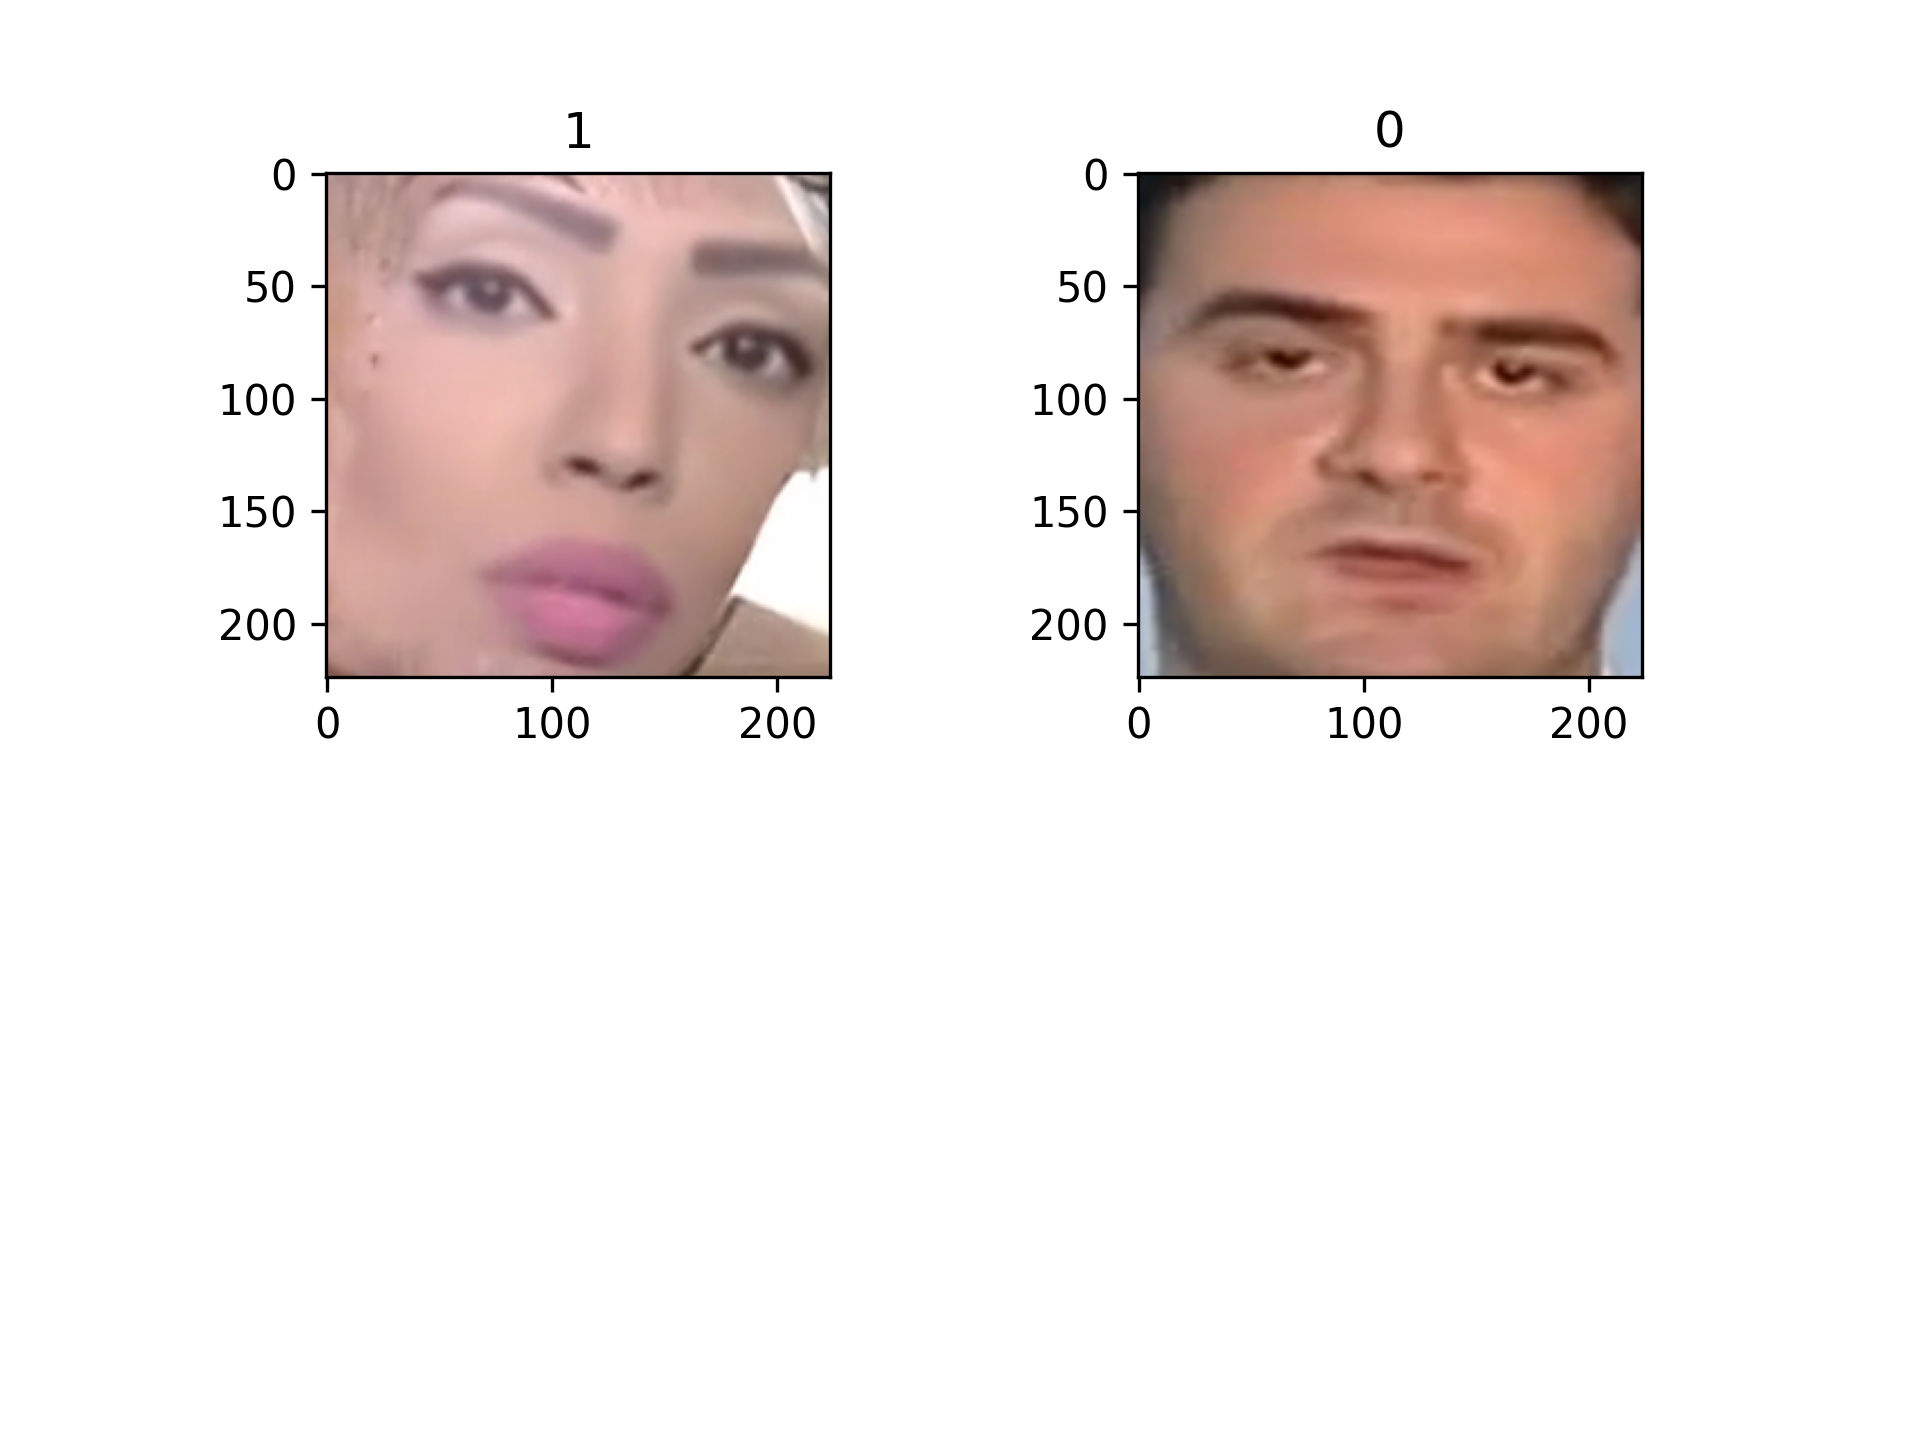

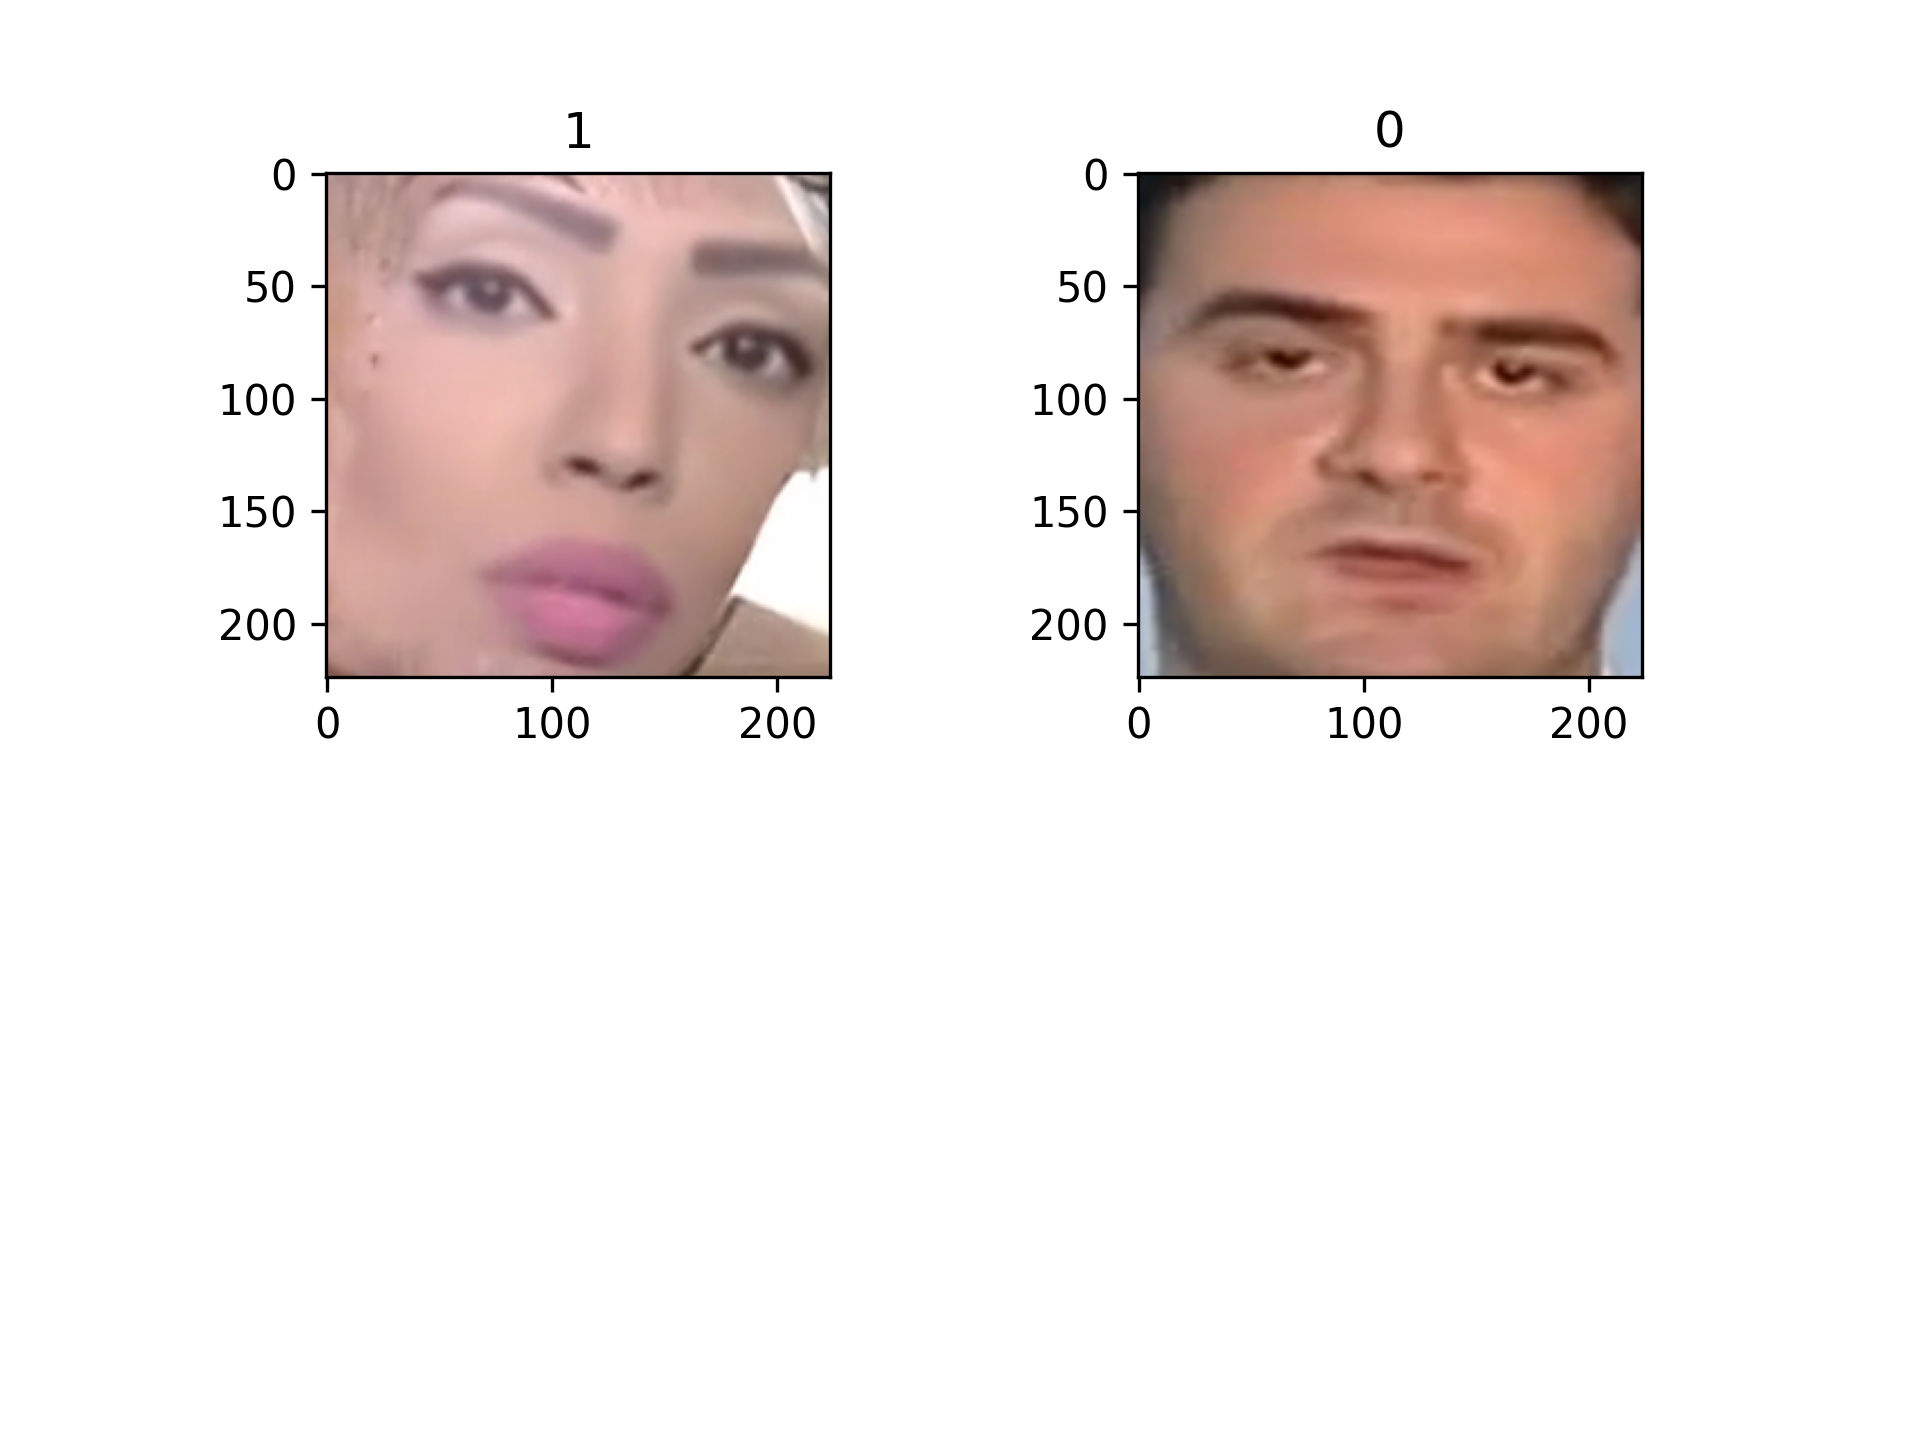

In [107]:
images1, images2, labels = next(iter(test_loader))

plot_images(images1[2:], labels.tolist(), max_num_images_to_plt=2)
plot_images(images2[2:], labels.tolist(), max_num_images_to_plt=2)

### 2D Embeddings - Deepfakes + Real

In [41]:
from itertools import compress

In [46]:
lst1 = [1 ,0 ,1 ,0]
tst_list = [5, 2 ,3 ,4]
indx_list = [True if x==1 else False for x in lst1]
print(indx_list)
final = list(compress(tst_list, indx_list))
print(final)

[True, False, True, False]
[5, 3]


In [39]:
print(indx_list)

[True, False, False, False]


In [56]:
embds_list = embeds.tolist()
targets_list = targets.tolist()
indices = [True if x==1 else False for x in targets_list]
embds_list = list(compress(embds_list, indices))
targets_list = list(compress(targets_list, indices))

In [57]:
print(len(embds_list))
print(len(targets_list))

992
992


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 992 samples in 0.141s...
[t-SNE] Computed neighbors for 992 samples in 4.761s...
[t-SNE] Computed conditional probabilities for sample 992 / 992
[t-SNE] Mean sigma: 9.737003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.705757
[t-SNE] KL divergence after 1000 iterations: 0.395079
num categories: 2


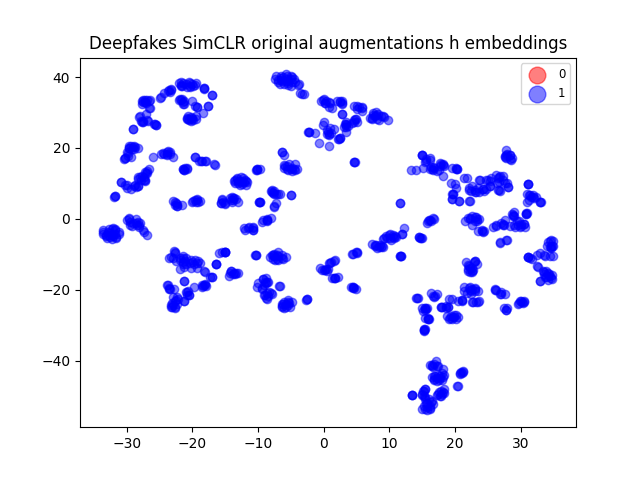

In [61]:
plot_embeddings_2D(embds_list, targets_list, 'Deepfakes SimCLR original augmentations h embeddings')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.176s...
[t-SNE] Computed neighbors for 1000 samples in 4.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.935383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.665771
[t-SNE] KL divergence after 1000 iterations: 0.526231
num categories: 2


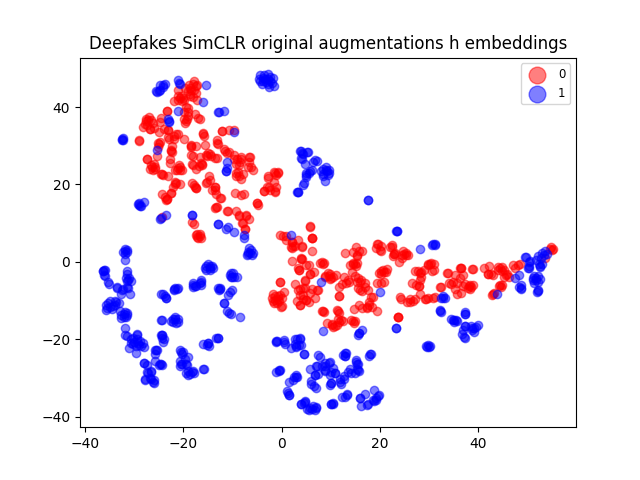

In [26]:
plot_embeddings_2D(embeds.tolist(), targets.tolist(), 'Deepfakes SimCLR original augmentations h embeddings')

### 3D Embeddings - Deepfakes + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.178s...
[t-SNE] Computed neighbors for 1000 samples in 4.841s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 7.935383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.462807
[t-SNE] KL divergence after 1000 iterations: 0.394035


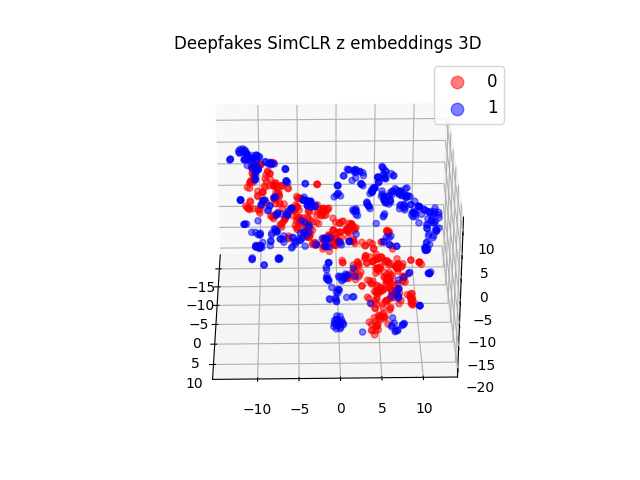

In [27]:
plot_embeddings_3D(embeds.tolist(), targets.tolist(), 'Deepfakes SimCLR z embeddings 3D')

## Face2Face

In [28]:
f2f_test_loader = load_ff_ds_test(2000, 16, load_face2face=True, transform=clean_transform)

loading real images...
real images loaded!
loading face2face...
face2face loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 73770
fakes masks len: 73770
final imgs len: 147538
final masks len: 147538
asserting order
assertion passed!
before eq: real: 73768  fake: 73770  total: 147538
after eq: total: 147536
test size: 2000


In [30]:
f2f_unnorm_embeds, f2f_embeds, f2f_targets = get_embeds(model, f2f_test_loader, DEVICE, out='h')

100%|██████████| 125/125 [01:18<00:00,  1.59it/s]


### Plot example images

In [ ]:
images, _, labels = next(iter(f2f_test_loader))
plot_images(images, labels.tolist(), max_num_images_to_plt=2)

### 2D Embeddings - Face2Face + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.533s...
[t-SNE] Computed neighbors for 2000 samples in 18.306s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 8.239342
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.071960
[t-SNE] KL divergence after 1000 iterations: 0.435985
num categories: 2


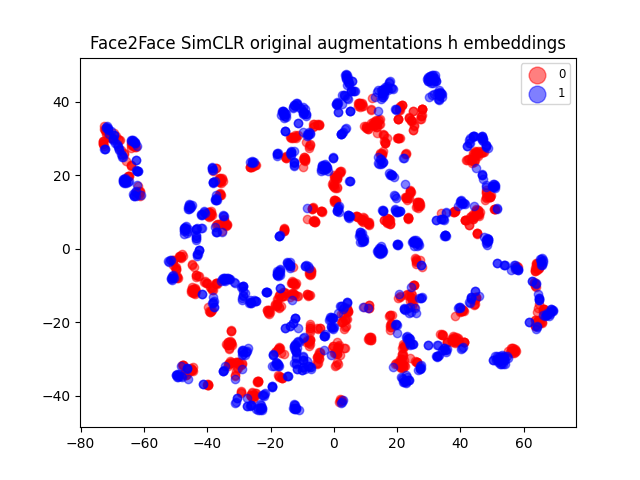

In [31]:
plot_embeddings_2D(f2f_embeds.tolist(), f2f_targets.tolist(), 'Face2Face SimCLR original augmentations h embeddings')

### 3D Embeddings - Face2Face + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.422s...
[t-SNE] Computed neighbors for 2000 samples in 17.855s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 8.239342
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.773170
[t-SNE] KL divergence after 1000 iterations: 0.357252


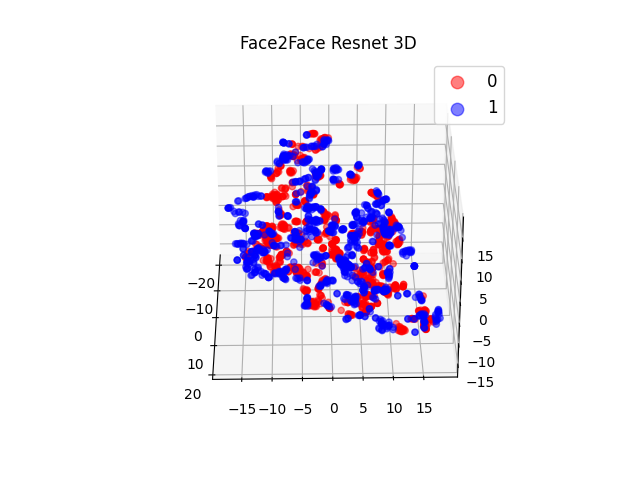

In [32]:
plot_embeddings_3D(f2f_embeds.tolist(), f2f_targets.tolist(), 'Face2Face Resnet 3D')

## NeuralTextures

In [14]:
nt_test_loader = load_ff_ds_test(2000, 16, load_neural_textures=True)

loading real images...
real images loaded!
loading neural textures...
neural textures loaded!
real imgs len: 73768
masks len: 73768
fakes imgs len: 56951
fakes masks len: 56951
final imgs len: 130719
final masks len: 130719
asserting order
assertion passed!
before eq: real: 73768  fake: 56951  total: 130719
after eq: total: 130719
test size: 2000


In [15]:
nt_unnorm_embeds, nt_embeds, nt_targets = get_embeds(model, nt_test_loader, DEVICE, out='h')

100%|██████████| 125/125 [03:35<00:00,  1.72s/it]


### Plot example images

In [ ]:
images, _, targets = next(iter(test_loader))
plot_images(images, targets.tolist(), max_num_images_to_plt=2)

### 2D Embeddings - NeuralTextures + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.462s...
[t-SNE] Computed neighbors for 2000 samples in 17.522s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.231807
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.808189
[t-SNE] KL divergence after 1000 iterations: 1.075828
num categories: 2


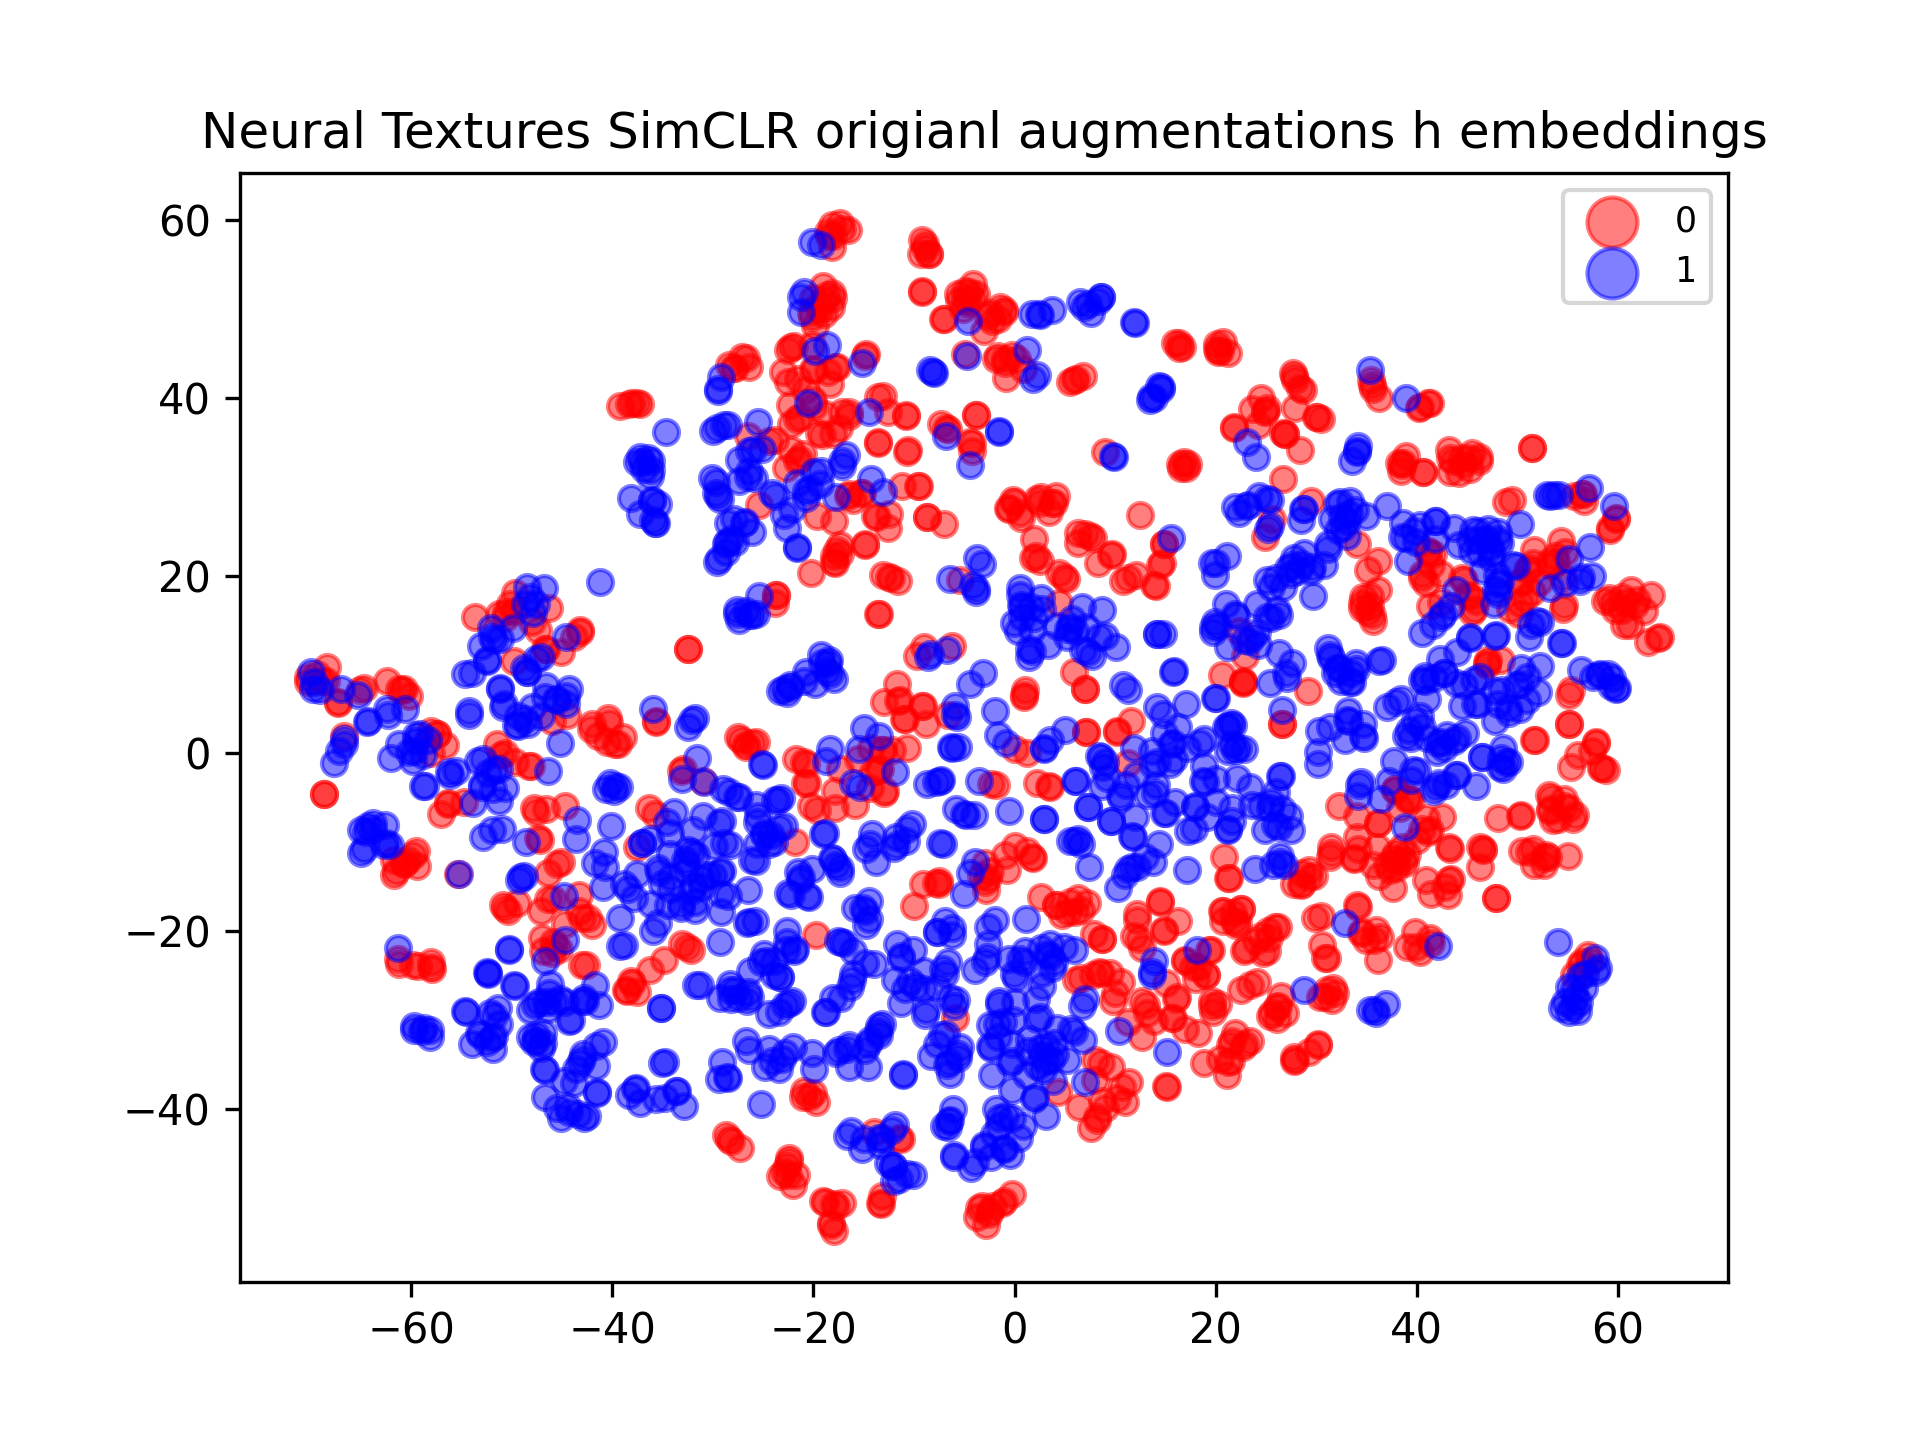

In [16]:
plot_embeddings_2D(nt_embeds.tolist(), nt_targets.tolist(), 'Neural Textures SimCLR origianl augmentations h embeddings')

### 3D Embeddings - NeuralTextures + Real

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.436s...
[t-SNE] Computed neighbors for 2000 samples in 12.679s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.003353
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.390884
[t-SNE] KL divergence after 1000 iterations: 0.743461


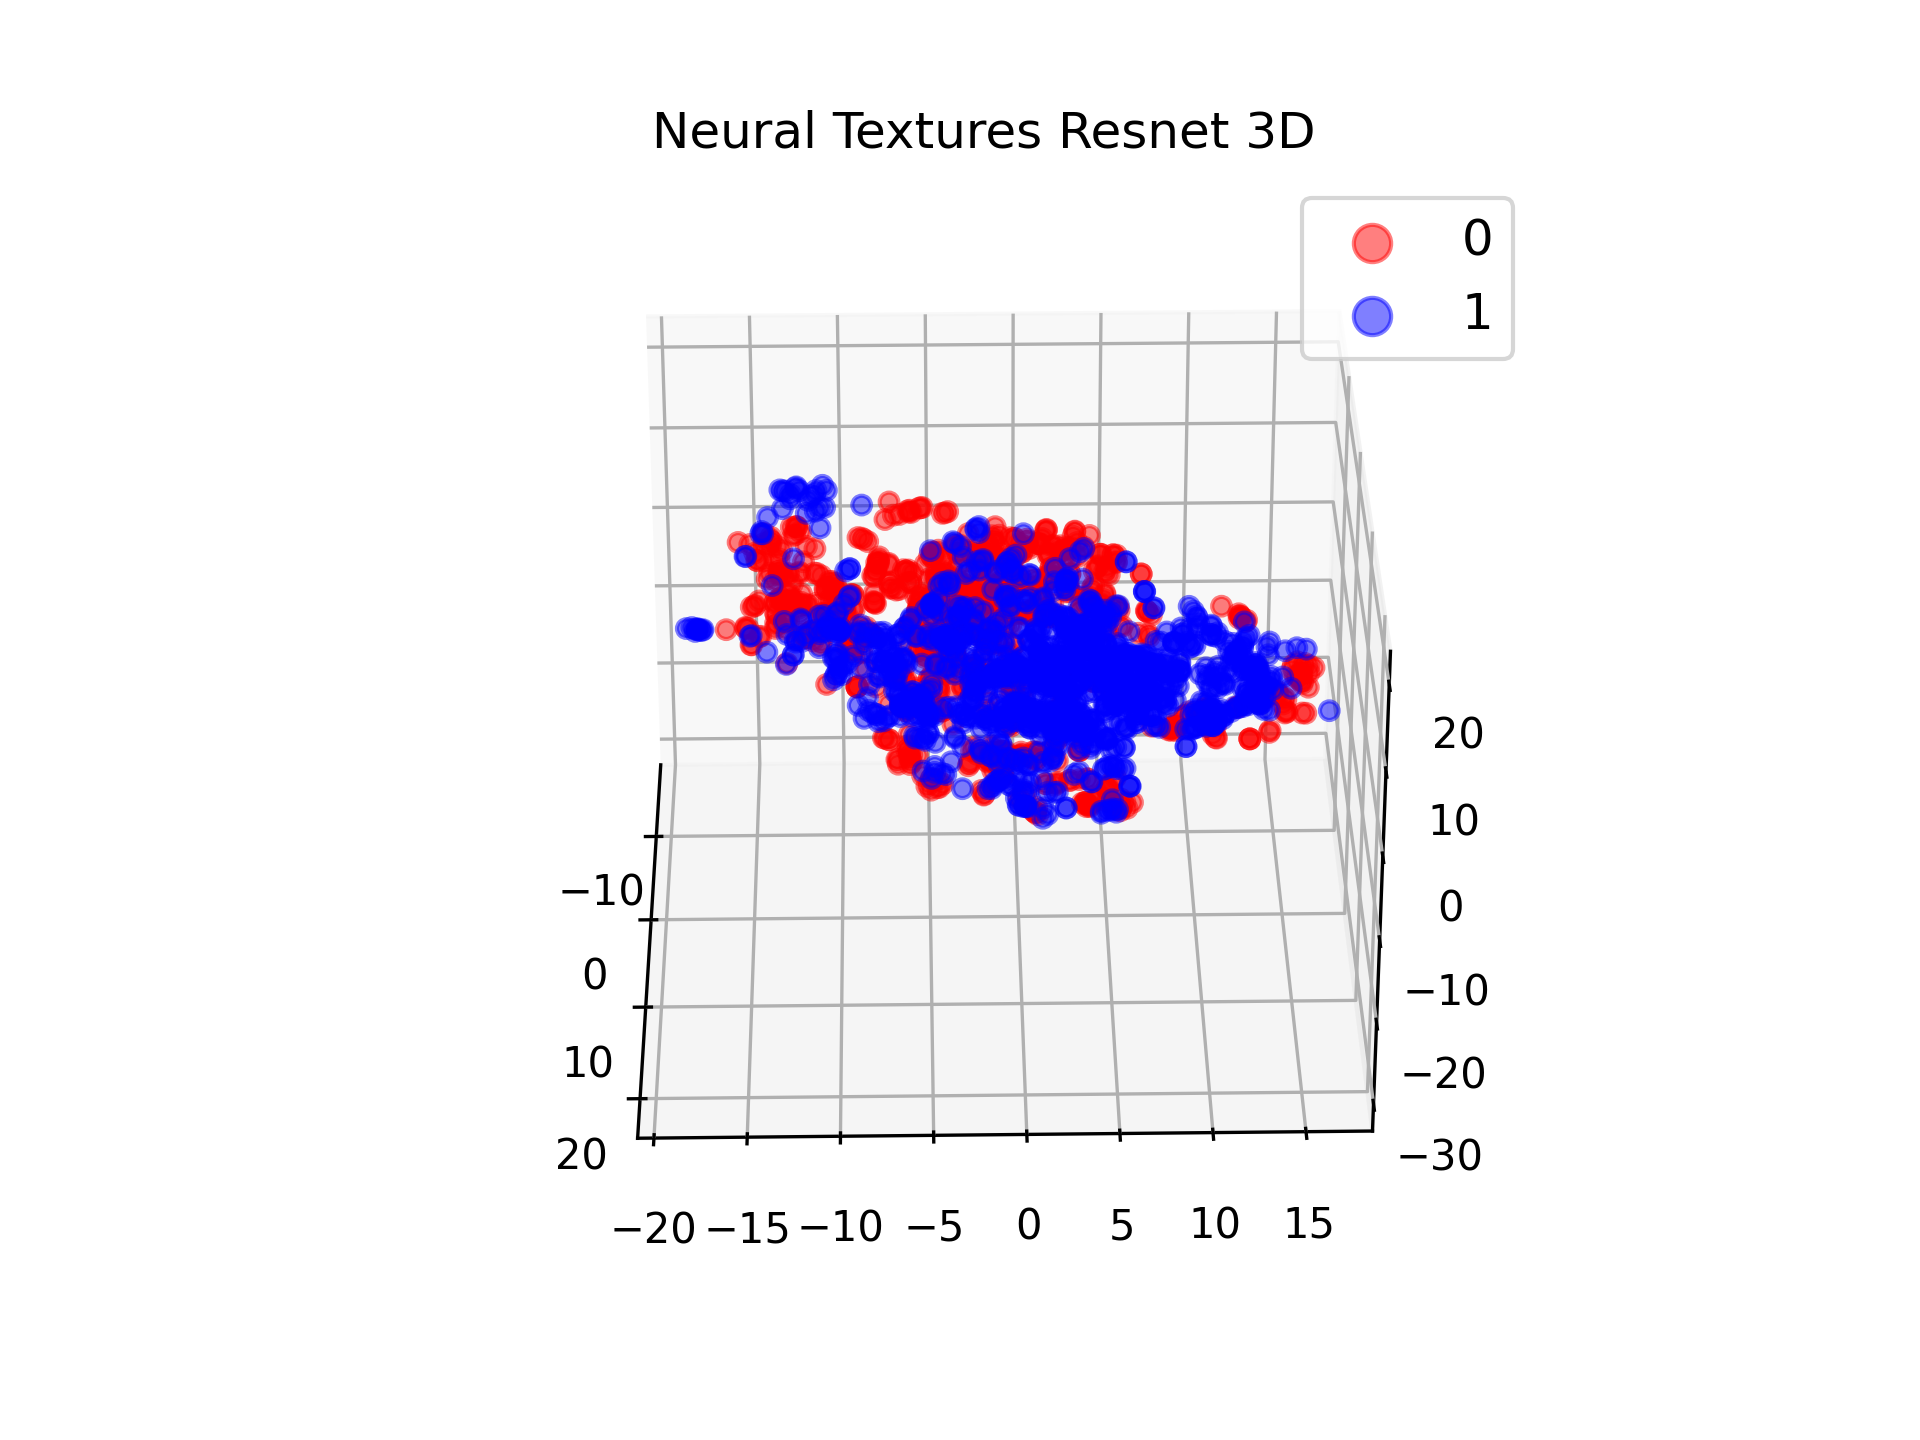

In [37]:
plot_embeddings_3D(nt_embeds.tolist(), nt_targets.tolist(), 'Neural Textures Resnet 3D')